HSE, Applied Time Series Forecasitng , Winter 2022-23 

<font color="blue"> Lesson #9: TS Segmentation approaches</font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - Time Series Segmentation, TS Clustering, Seasonality Testing

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 

# don't forget to upload utils file to the colab session
import warnings

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# Time Series Segmentation: Overview

**Question**
 * What is the purpose of TS segmenation? What TS can we call as "similar"?
   - Two time series are similar if they have about the same level (mean) value
   - Two time series are similar if they have the same hidden component (trend, seasonality, intermittency)



# Clustering based on Demand Behaviour to define ML Training pipeline
**Question:** How to split all timeseries with about the same structure?

*Idea: apply clustering algorithms to lagged features.



In [ ]:
# Loading data
ts_retail = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv', sep=';')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
ts_retail.set_index(['Date'], inplace=True)
ts_retail.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-02,1,1,NaN,41.0,163.78,NaN
2015-01-03,1,1,NaN,35.0,163.78,NaN
2015-01-04,1,1,NaN,72.0,163.78,NaN
2015-01-05,1,1,NaN,25.0,163.78,NaN


In [ ]:
ts_retail['SKU_id'].unique()

array([1, 2])

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2016-06-10', '2016-06-11', '2016-06-12', '2016-06-13',
               '2016-06-14', '2016-06-15', '2016-06-16', '2016-06-17',
               '2016-06-18', '2016-06-19'],
              dtype='datetime64[ns]', name='Date', length=92886, freq=None)

In [ ]:
# top_sum = ts_retail.groupby('SKU_id').sum()[['Demand']]
# top_sum['percent'] = top_sum['Demand']/top_sum['Demand'].sum()
# top_SKU = list((top_sum['percent'] >= 0.01).index)
# demand_top_sku = ts_retail.index
# [ SKU in top_SKU for SKU in ts_retail['SKU_id'] ]
demand_top_sku_pivot = pd.pivot_table(demand_top_sku.groupby(['SKU_id', 'Store_id']).mean()['Demand'].reset_index(), 
                                      index='Store_id', values='Demand', columns='SKU_id', fill_value=0).rename_axis(None, axis=1)
demand_top_sku_pivot

,1,2
Store_id,,
1,260.531496,14.726378
2,625.015748,19.470472
3,378.708661,9.431102
4,422.751969,10.895669
5,570.673228,18.431102
...,...,...
99,378.585106,7.500000
100,173.166667,22.333333
104,188.791667,4.291667


In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

1


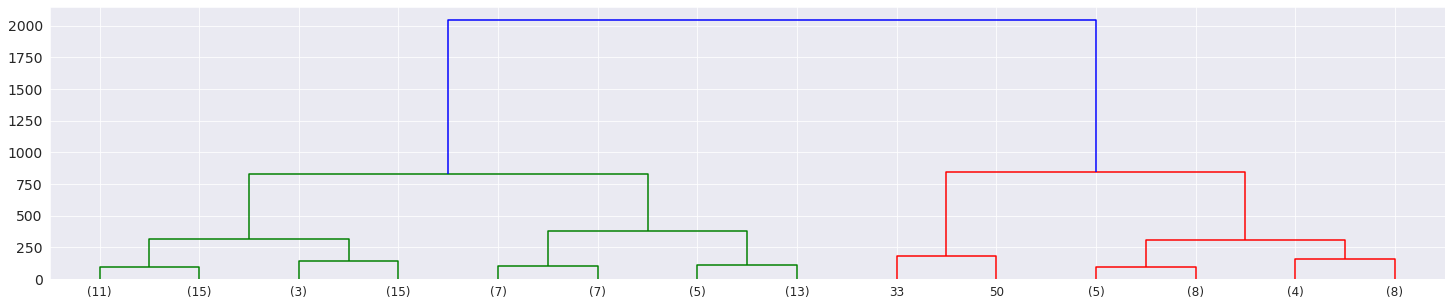

In [ ]:
# for SKU in ts_retail['SKU_id'].unique():
print(SKU)
# select TOP SKU (in case there are a lot of SKU)
top_sum = ts_retail.groupby('SKU_id').sum()[['Demand']]
top_sum['percent'] = top_sum['Demand']/top_sum['Demand'].sum()
top_SKU = list((top_sum['percent'] >= 0.01).index)
demand_top_sku = ts_retail[[ SKU in top_SKU for SKU in ts_retail['SKU_id'] ]]

demand_top_sku_pivot = pd.pivot_table(demand_top_sku.groupby(['SKU_id', 'Store_id']).mean()['Demand'].reset_index(), 
                                      index='Store_id', values='Demand', columns='SKU_id', fill_value=0).rename_axis(None, axis=1)



agcl =  AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agcl = agcl.fit(demand_top_sku_pivot)
# plot the top three levels of the dendrogram
plot_dendrogram(agcl, truncate_mode="level", p=3)

In [ ]:
N_CLUSTERS = 4 # number of custers can be defined using dendrogram
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demand_top_sku_pivot)
# cluster_labels = cluster_labels
# clustered_store = pd.DataFrame(cluster_labels, index=demand_top_sku_pivot.index, columns=['cluster_label'])

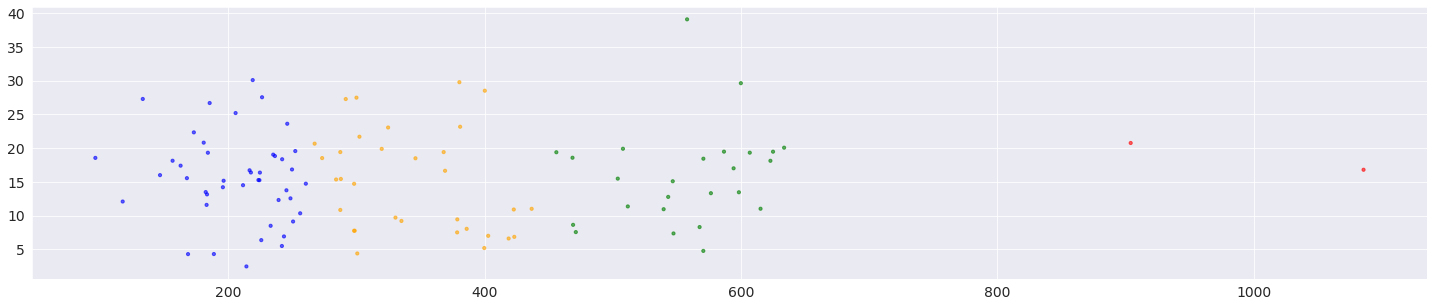

In [ ]:
# plot clusters
colors = ['orange','blue', 'red', 'green']
plt.scatter(demand_top_sku_pivot[1], demand_top_sku_pivot[2], c=[colors[x] for x in cluster_labels], alpha = 0.6, s=10)

# TS Segmentation to define TS-Forecasting Pipeline

# Building Time Series Forecastability Index
Those Time Series that have about the same accuracy level should have the same $\color{red}{Forecastability~Index}$.



<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Forecastability%20Index.png?raw=true' width = 500pt>

Techniques to do it
* STL decomposition (detecting trend and seasonality) https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html

* ABC splitting (to segment by Demand Velocity and Demand Variability) https://pypi.org/project/abc-analysis/

or <a href = 'https://excel.city/2015/01/methods-of-classification-in-abc-analysis/'>more advanced tecniques </a>

* Intermittency time series tests 


In [ ]:
!pip install abc_analysis

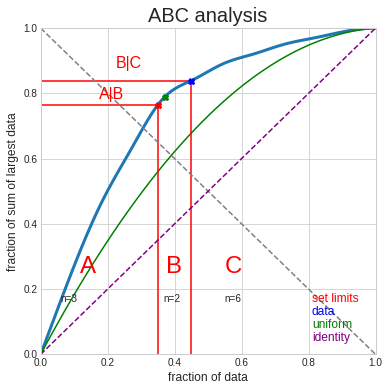

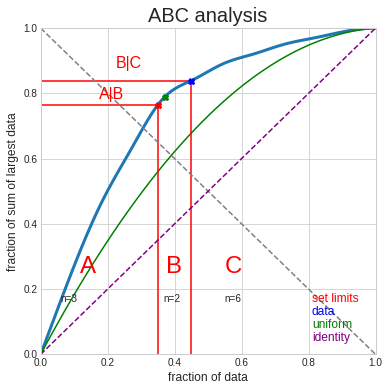

In [ ]:
import abc_analysis
from abc_analysis import abc_analysis, abc_plot

# Perform an ABC analysis on a numeric vector (without plotting)
dctAnalysis = abc_analysis([1, 15, 25, 17, 2, 3, 5, 6, 2, 3, 22])

# Perform an ABC analysis with plotting
dctAnalysis = abc_analysis([1, 15, 25, 17, 2, 3, 5, 6, 2, 3, 22], True)

# Plot saved results of an ABC analysis
abc_plot(dctAnalysis)

# Conclusion

* TS segmentation can be done by many different approaches
  - Building of ML models dimensions can be perfomed with Clustering algorithms
  - Building of Forecastability groups can be done with some conservative segmentation techniques  

## Materials
* List of TS forecasting packages in Python https://github.com/aromanenko/ATSF/wiki/List-of-packages-for-Time-Series-Forecasting-in-Python
* List of TS forecasitng packages in R https://github.com/aromanenko/ATSF/wiki/List-of-Packages-for-Time-Series-Forecatging-in-R
